In [12]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [45]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from pprint import pprint

In [46]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [47]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [48]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [49]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(engine, reflect=True)

In [50]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [51]:
# Save references to each table
Measurement = Base.classes.measurement
Measurement


sqlalchemy.ext.automap.measurement

In [52]:
# Create our session (link) from Python to the DB
Station = Base.classes.station
Station

sqlalchemy.ext.automap.station

In [53]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

In [54]:
# Creating the inspector and connecting it to the engine:
inspector = inspect(engine)

# Collecting the names of the tables within the database:
inspector.get_table_names()

['measurement', 'station']

In [55]:
# Using the inspector to print the column names within the 'Measurement' table and its types:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [56]:
# Using the inspector to print the column names within the 'Station' table and its types:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [57]:
# Retrieving the earliest date:
earliest_query = session.query(Measurement.date)\
            .order_by(Measurement.date)\
            .first()
print(f"Earliest date is: {earliest_query[0]}")

Earliest date is: 2010-01-01


In [58]:
# Retrieving the latest date to design query for climate analysis 
latest_date = session.query(Measurement.date)\
            .order_by(Measurement.date.desc())\
            .first()
end_date = dt.datetime(2017,8,23)
print(f"Latest date is: {end_date}")

Latest date is: 2017-08-23 00:00:00


In [59]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
target_date = dt.date(2017, 8, 23)
delta = dt.timedelta(days=365)
query_date = target_date - delta
print(f"Query date is: {query_date}")

Query date is: 2016-08-23


In [60]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp)\
        .filter(Measurement.date >= query_date)\
        .filter(Measurement.date <= end_date)\
        .all()
results[:5]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0)]

In [61]:
# Unpacking the precipitation data from the results and saving into seperate lists:
date = [r[0] for r in results]
prcp = [r[1] for r in results]

# Save the query results as a Pandas DataFrame and set the index to the date column
# Creating the new dataframe for plotting:
prec_date_df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
prec_date_df.set_index('Date', inplace=True)
prec_date_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [62]:
prec_date_df = prec_date_df.sort_index()

# Sort the dateframe by date
prec_date_df = prec_date_df.sort_values(by='Date')
prec_date_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


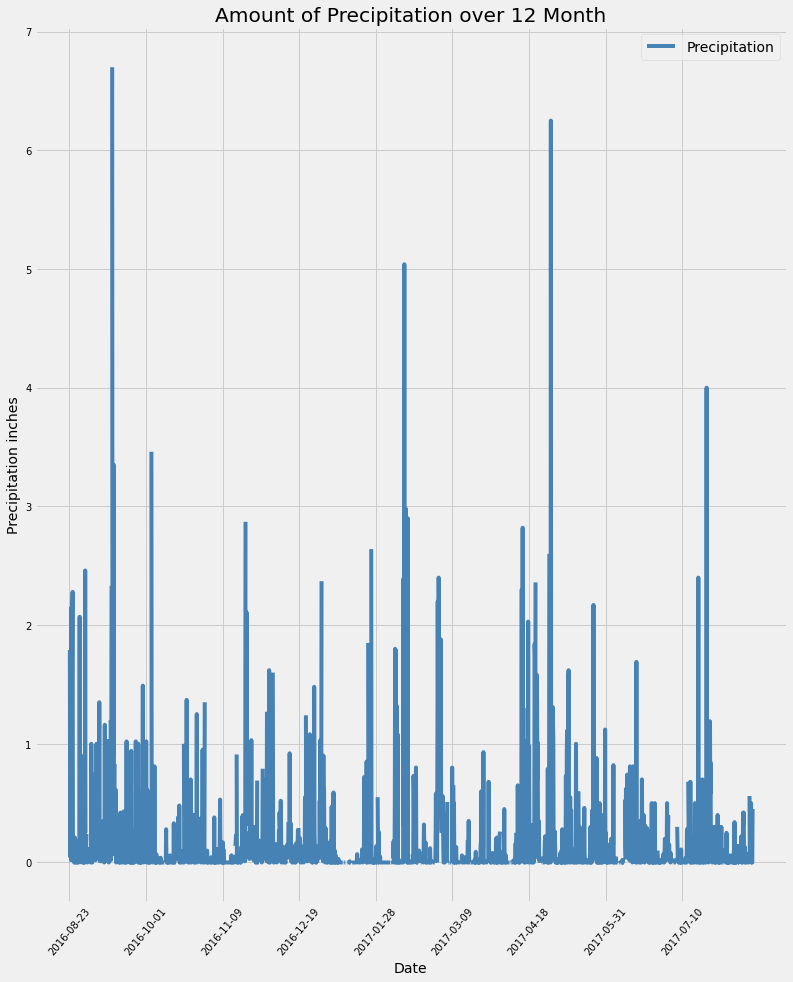

In [63]:
# Using Pandas Plotting with Matplotlib to plot the data
prec_date_df.plot(use_index=False, rot=50, figsize=(12,15), fontsize=10, color="steelblue")
#  Create list of all dates
data_date = prec_date_df.index
# # Create list of indexes of all dates
list_date_index = [*range(len(data_date))]
# # Indicate the xtick positions > plt.xticks( np.arange( min(x-axis), max(x-axis)+1, frequency) )
positions = np.arange(min(list_date_index), max(list_date_index)+1, 250)
# # Create empty list of dates to plot
labels = []
# # For loop to add dates to labels list
for i in positions:
   labels.append(data_date[i])
# # Use this code for adjust the xticks
plt.xticks(positions, labels)
plt.ylabel("Precipitation inches", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.legend(["Precipitation"],loc="best")
plt.title("Amount of Precipitation over 12 Month")
plt.savefig("Images/precipitation_data.png")

In [64]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_date_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [65]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.id).count()
print(f"Number of stations are: {stations}")

Number of stations are: 9


In [66]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, Station.name, func.count(Measurement.id))\
                .filter(Measurement.station == Station.station)\
                .group_by(Measurement.station)\
                .order_by(func.count(Measurement.id).desc())\
                .all()

print(f"The most active stations are:")
pprint(most_active_stations)

The most active stations are:
[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]


In [67]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_variation = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
                .filter(Measurement.station == most_active_stations[0][0])\
                .all()
print(f"The most active station is: {most_active_stations[0][0]} - {most_active_stations[0][1]}")
print(f"Temperature records for the most active station are:")
print(f"The lowest temperature is: {temp_variation[0][0]}F")
print(f"The highest temperature is: {temp_variation[0][1]}F")
print(f"The average temperature is: {temp_variation[0][2]}F")

The most active station is: USC00519281 - WAIHEE 837.5, HI US
Temperature records for the most active station are:
The lowest temperature is: 54.0F
The highest temperature is: 85.0F
The average temperature is: 71.66378066378067F


In [68]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
WAIHEE_station = session.query(Measurement.date, Measurement.tobs)\
                .filter(Measurement.station == most_active_stations[0][0])\
                .filter(Measurement.date <= end_date)\
                .filter(Measurement.date >= query_date)\
                .all()
print(f"Temperature observation data for WAIHEE station:")
WAIHEE_station[:5]

Temperature observation data for WAIHEE station:


[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0)]

In [69]:
# Unpacking the temperature observation for WAIHEE station and saving into seperate lists:
date = [r[0] for r in WAIHEE_station]
temp = [r[1] for r in WAIHEE_station]

new_WAIHEE_df = pd.DataFrame(WAIHEE_station, columns=['Date', 'Temperature'])
new_WAIHEE_df.set_index('Date', inplace=True)
new_WAIHEE_df.head()

,Temperature
Date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


In [70]:
new_WAIHEE_df = new_WAIHEE_df.sort_index()

# Sorting the dataframe for the station:
new_WAIHEE_df = new_WAIHEE_df.sort_values(by='Date', ascending=True)
new_WAIHEE_df.head()

,Temperature
Date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


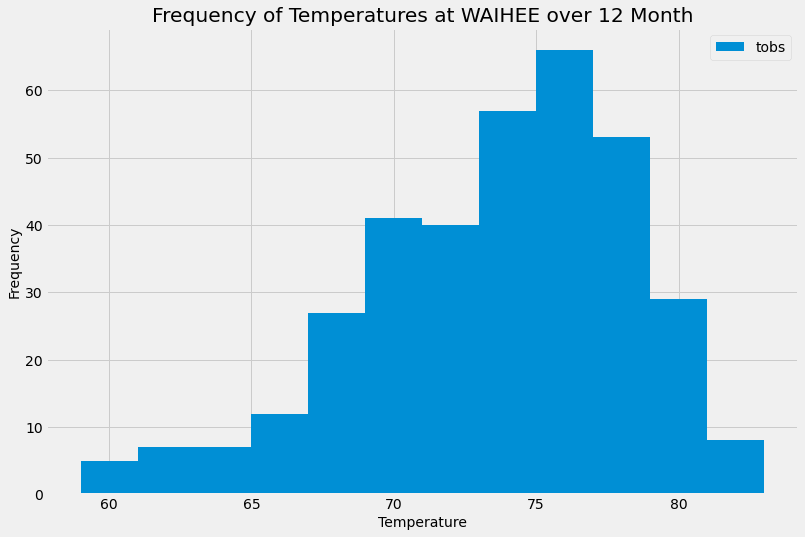

In [71]:
# Histogram plotting of the past 12 months of temperature observation of WAIHEE station:
new_WAIHEE_df.plot.hist(bins=12, rwidth=1.0, figsize=(12,8))
plt.legend(["tobs"],loc="best")
plt.xlabel("Temperature", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Frequency of Temperatures at WAIHEE over 12 Month")
plt.savefig("Images/station_temp_observation.png")

## Bonus Challenge Assignment

In [72]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [73]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = dt.date(2017, 12, 6) - dt.timedelta(days=365)
trip_end = dt.date(2017, 12, 13) - dt.timedelta(days=365)

trips_temp = calc_temps(trip_start, trip_end)
tmin, tavg, tmax = trips_temp[0]

print(f"Trip's weather results are:")
print(f"Min Temp: {tmin}F")
print(f"Max Temp: {tmax}F")
print(f"Avg Temp: {tavg}F")

Trip's weather results are:
Min Temp: 65.0F
Max Temp: 78.0F
Avg Temp: 70.09803921568627F


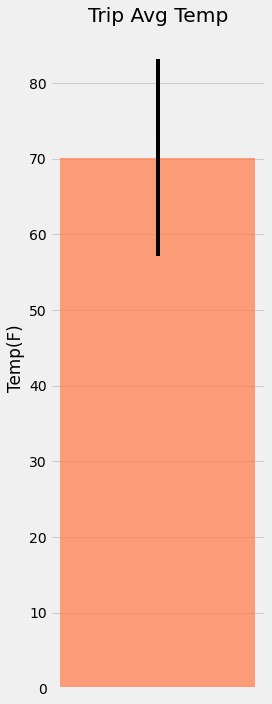

In [74]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = tmax - tmin
xpos = 1
plt.figure(figsize=(4,10))
plt.bar(xpos, tavg, yerr=error, alpha=0.75, color="coral")
plt.title("Trip Avg Temp")
plt.ylabel("Temp(F)")
plt.xticks([])
plt.tight_layout()
plt.savefig("Images/trip_avg_temp.png")

In [78]:
trip_start = dt.date(2017, 12, 6) - dt.timedelta(days=365)
trip_end = dt.date(2017, 12, 13) - dt.timedelta(days=365)

In [76]:
# Creating new dataframe:
stations_rainfall_df = pd.DataFrame(rainfall_by_station)
stations_rainfall_df

,station,name,latitude,longitude,elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [77]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [79]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_by_station = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation)\
                    .filter(Measurement.date >= trip_start)\
                    .filter(Measurement.date <= trip_end)\
                    .filter(Station.station == Measurement.station)\
                    .group_by(Measurement.station)\
                    .order_by(func.sum(Measurement.prcp).desc())\
                    .all()

In [80]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [81]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
trip_start = '2017-12-06'
trip_end = '2017-12-13'

# Use the start and end date to create a range of dates
trip_date_range = pd.date_range(trip_start, trip_end, freq='D')

# Stip off the year and save a list of %m-%d strings
trip_month_day = trip_date_range.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
for date in trip_month_day:
    normals.append(*daily_normals(date))
print(f" The daily normals are:")  
normals

 The daily normals are:


[(61.0, 69.3921568627451, 78.0),
 (58.0, 69.2, 79.0),
 (60.0, 70.27450980392157, 83.0),
 (64.0, 71.90196078431373, 80.0),
 (61.0, 71.24528301886792, 78.0),
 (64.0, 72.38775510204081, 78.0),
 (64.0, 70.88235294117646, 79.0),
 (65.0, 70.9423076923077, 80.0)]

In [82]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
normals_df['Date'] = trip_date_range
normals_df.set_index(['Date'], inplace=True)
normals_df

,tmin,tavg,tmax
Date,,,
2017-12-06,61.0,69.392157,78.0
2017-12-07,58.0,69.200000,79.0
2017-12-08,60.0,70.274510,83.0
2017-12-09,64.0,71.901961,80.0
2017-12-10,61.0,71.245283,78.0
2017-12-11,64.0,72.387755,78.0
2017-12-12,64.0,70.882353,79.0
2017-12-13,65.0,70.942308,80.0


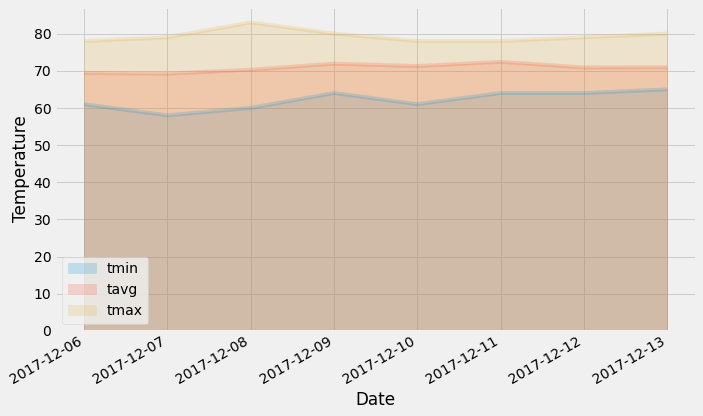

In [83]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', stacked=False, x_compat=True, alpha=0.2, figsize=(10,6))
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.tight_layout()
plt.savefig("Images/daily_normals.png")